# Analysis of voter turnout of Municipalities of Switzerland

## Install and import libraries

In [1]:
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install nbconvert[webpdf]

In [40]:
import math
import copy
import json
import sys

from PIL import Image

import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt 
import statsmodels.api   as sm

from sklearn         import linear_model
from sklearn.metrics import r2_score

from scipy.stats import linregress
from scipy.stats import norm 
from scipy       import stats 

from bokeh.plotting import figure, show
from bokeh.palettes import Inferno11
from bokeh.layouts  import column, row
from bokeh.models   import ColumnDataSource, LabelSet, Slope, TextInput
from bokeh.models   import InlineStyleSheet, Button, RangeSlider, CustomJS, Title
from bokeh          import events

## Load data

In [3]:
municipalities = pd.read_csv("data/preprocessed/je-d-21.03.01-gemeindeportraits-preprocessed.csv",       sep=";")
turnouts2023   = pd.read_csv("data/original/sd-t-17.02-NRW2023-wahlbeteiligung-appendix.csv",            sep=";")
turnouts2019   = pd.read_csv("data/original/sd-t-17.02-NRW2019-wahlbeteiligung-gemeinden-APPENDIX.csv",  sep=";")

# Élections cantonales neuchâteloises de 2021: Evolution du taux de participation
# https://www.ne.ch/autorites/CHAN/CHAN/elections-votations/stat/Pages/210418.aspx
turnoutsNE     = pd.read_csv("data/preprocessed/ne-2021-04-18-cantonal-elections.csv",                    sep=";")

## Select relevant columns and rows

In [4]:
turnouts2023 = turnouts2023.loc[turnouts2023["ebene_resultat"] != "Schweiz" ]
turnouts2023 = turnouts2023.loc[turnouts2023["ebene_resultat"] != "Kanton" ]

turnouts2019 = turnouts2019[ ["gemeinde_bezeichnung", "wahlbeteiligung"] ]
turnouts2023 = turnouts2023[ ["geoLevelName", "wahlbeteiligung"] ]
municipalities.drop(columns=["Number of commune"], inplace=True)

In [5]:
turnouts2023.head(100)

,geoLevelName,wahlbeteiligung
27,Aeugst am Albis,58.887283
28,Affoltern am Albis,45.041209
29,Bonstetten,54.920286
30,Hausen am Albis,52.651660
31,Hedingen,59.182879
...,...,...
122,Herrliberg,59.497535
123,Hombrechtikon,47.622318
124,Küsnacht (ZH),56.171857
125,Männedorf,56.208367


In [6]:
municipalities.head(10)

,Name of commune,Residents,Change in %,Population density per km²,Foreign nationals in %,0-19 years,20-64 years,65 years or over,Crude marriage rate,Crude divorce rate,...,Primary sector,Secondary sector,Tertiary sector,Business establishments total,Primary sector.1,Secondary sector.1,Tertiary sector.1,Dwelling vacancy rate,New housing units per 1000 residents,Social assistance rate
0,Aeugst am Albis,1981,8.607456,250.442478,14.184755,19.787986,62.190813,18.021201,7.065355,2.018673,...,39.0,25.0,378.0,141.0,15.0,16.0,110.0,5.291577,13.910355,1.01
1,Affoltern am Albis,12303,10.927779,1161.756374,28.700317,20.165813,61.667886,18.166301,5.543780,1.793576,...,47.0,1307.0,5566.0,995.0,23.0,134.0,838.0,1.005548,3.787255,3.02
2,Bonstetten,5572,8.005427,749.932705,16.564968,23.636037,59.834889,16.529074,4.316547,1.798561,...,34.0,111.0,869.0,281.0,14.0,26.0,241.0,1.171717,0.181422,1.51
3,Hausen am Albis,3751,11.636905,275.808824,16.022394,22.180752,59.824047,17.995201,3.220612,1.610306,...,93.0,136.0,792.0,271.0,36.0,38.0,197.0,0.630011,3.002183,1.19
4,Hedingen,3778,10.791789,578.560490,16.410799,21.625199,61.646374,16.728428,3.727370,2.129925,...,29.0,679.0,770.0,201.0,11.0,26.0,164.0,0.962696,3.248511,1.47
5,Kappel am Albis,1221,33.006536,154.166667,17.526618,24.979525,61.179361,13.841114,3.364172,0.000000,...,56.0,81.0,182.0,101.0,21.0,24.0,56.0,2.177858,37.333333,0.69
6,Knonau,2378,32.111111,367.542504,18.292683,24.348192,60.975610,14.676198,3.367712,0.841928,...,55.0,108.0,403.0,133.0,24.0,15.0,94.0,0.588235,5.639913,0.84
7,Maschwanden,645,4.707792,137.526652,12.868217,22.015504,59.534884,18.449612,3.074558,0.000000,...,49.0,49.0,77.0,67.0,18.0,7.0,42.0,2.990033,0.000000,NaN
8,Mettmenstetten,5200,22.554796,399.079048,14.769231,23.096154,59.211538,17.692308,5.051486,2.331455,...,148.0,545.0,987.0,319.0,51.0,58.0,210.0,1.325088,18.215309,1.61
9,Obfelden,5721,22.087068,758.753316,21.464779,23.579794,59.639923,16.780283,4.946996,1.943463,...,51.0,310.0,891.0,307.0,17.0,60.0,230.0,2.145411,7.281553,2.57


## Rename some column names

In [7]:
turnouts2023.rename(columns = {
    'wahlbeteiligung': 'turnout2023', 
    'geoLevelName':    'Municipality'
},  inplace = True)

In [8]:
turnouts2019.rename(columns = {
    'wahlbeteiligung':         'turnout2019', 
    'gemeinde_bezeichnung':    'Municipality'
},  inplace = True)

In [9]:
municipalities.rename(columns = {
  'Name of commune':          'Municipality',
  'Foreign nationals in %':   'Percentage of foreign nationals'
}, inplace = True)

## Define voter turnout columns

In [10]:
voter_turnout_columns = ['turnout2019', 'turnout2023', 'turnout_Neuchatel_2021']

## Merge data frames

In [11]:
data = pd.merge(municipalities, turnouts2023, on='Municipality', how='inner')
data = pd.merge(data, turnouts2019, on='Municipality', how='left')
data = pd.merge(data, turnoutsNE, on='Municipality', how='left')

In [12]:
# Check for missing values
data.describe()

,Residents,Change in %,Population density per km²,Percentage of foreign nationals,0-19 years,20-64 years,65 years or over,Crude marriage rate,Crude divorce rate,Crude birth rate,...,Business establishments total,Primary sector.1,Secondary sector.1,Tertiary sector.1,Dwelling vacancy rate,New housing units per 1000 residents,Social assistance rate,turnout2023,turnout2019,turnout_Neuchatel_2021
count,2125.000000,2125.000000,2125.000000,2125.000000,2125.000000,2125.000000,2125.000000,2125.000000,2125.000000,2125.000000,...,1847.000000,1983.000000,1973.000000,2106.000000,2125.000000,2125.000000,1666.000000,2125.000000,2109.000000,27.000000
mean,4030.299294,9.256887,443.038513,16.982469,20.479239,60.135396,19.385365,4.162261,1.913416,9.236059,...,350.722794,26.461422,48.080081,254.384615,1.955661,6.201701,2.221032,48.981709,47.110005,36.842222
std,13007.532108,11.363240,799.886967,9.691485,3.360905,3.151960,4.414778,2.473752,1.739153,3.832889,...,1422.078258,28.433032,103.072936,1240.555865,1.682093,8.483116,1.626392,7.967333,7.742767,7.483881
min,32.000000,-30.311778,0.860165,0.000000,2.127660,39.534884,6.461538,0.000000,0.000000,0.000000,...,9.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.220000,21.867322,23.160763,27.750000
25%,746.000000,2.512563,81.164179,9.602649,18.735363,58.286414,16.370968,2.874940,1.020408,7.073386,...,70.000000,9.000000,11.000000,34.000000,0.789889,0.759631,1.130000,43.862022,41.767442,30.270000
50%,1605.000000,7.993967,188.381331,15.184275,20.583942,60.249151,18.997575,4.040404,1.787630,9.259259,...,135.000000,17.000000,24.000000,76.000000,1.547531,3.375527,1.750000,48.763221,46.510873,36.210000
75%,3914.000000,14.401352,477.622378,23.188001,22.534404,62.137203,21.625409,5.202312,2.473207,11.194030,...,290.000000,33.000000,53.000000,188.750000,2.674230,8.253095,2.767500,53.611663,51.443375,40.440000
max,420217.000000,92.806484,12810.992462,57.773646,37.209302,81.081081,40.306834,29.197080,38.461538,46.979866,...,45057.000000,272.000000,2637.000000,42368.000000,13.099631,96.011817,11.210000,84.666667,85.350318,53.350000


## Create copy with standardized values

In [13]:
data_std = copy.deepcopy(data)
for column in data_std.columns:
  if column != "Municipality":
    data_std[column] = stats.zscore(data_std[column], nan_policy="omit")

## Histogram of voter turnout 2023

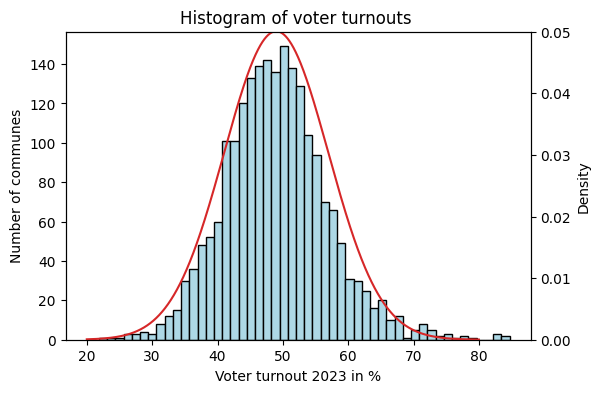

In [14]:
fig, ax1 = plt.subplots(1, 1,figsize=(6, 4))
plt.title("Histogram of voter turnouts ")
ax1.set_ylabel("Number of communes")
ax1.set_xlabel("Voter turnout 2023 in %")
ax1.hist(data['turnout2023'], bins=50, ec="black", color="lightblue")
ax2 = ax1.twinx()
ax2.set_ylim(bottom=0, top=0.05)
ax2.set_ylabel("Density")
ax2.plot(
    np.arange(20, 80, 0.01), 
    norm.pdf(np.arange(20, 80, 0.01), data['turnout2023'].mean(), data['turnout2023'].std()), 
    color='tab:red'
)

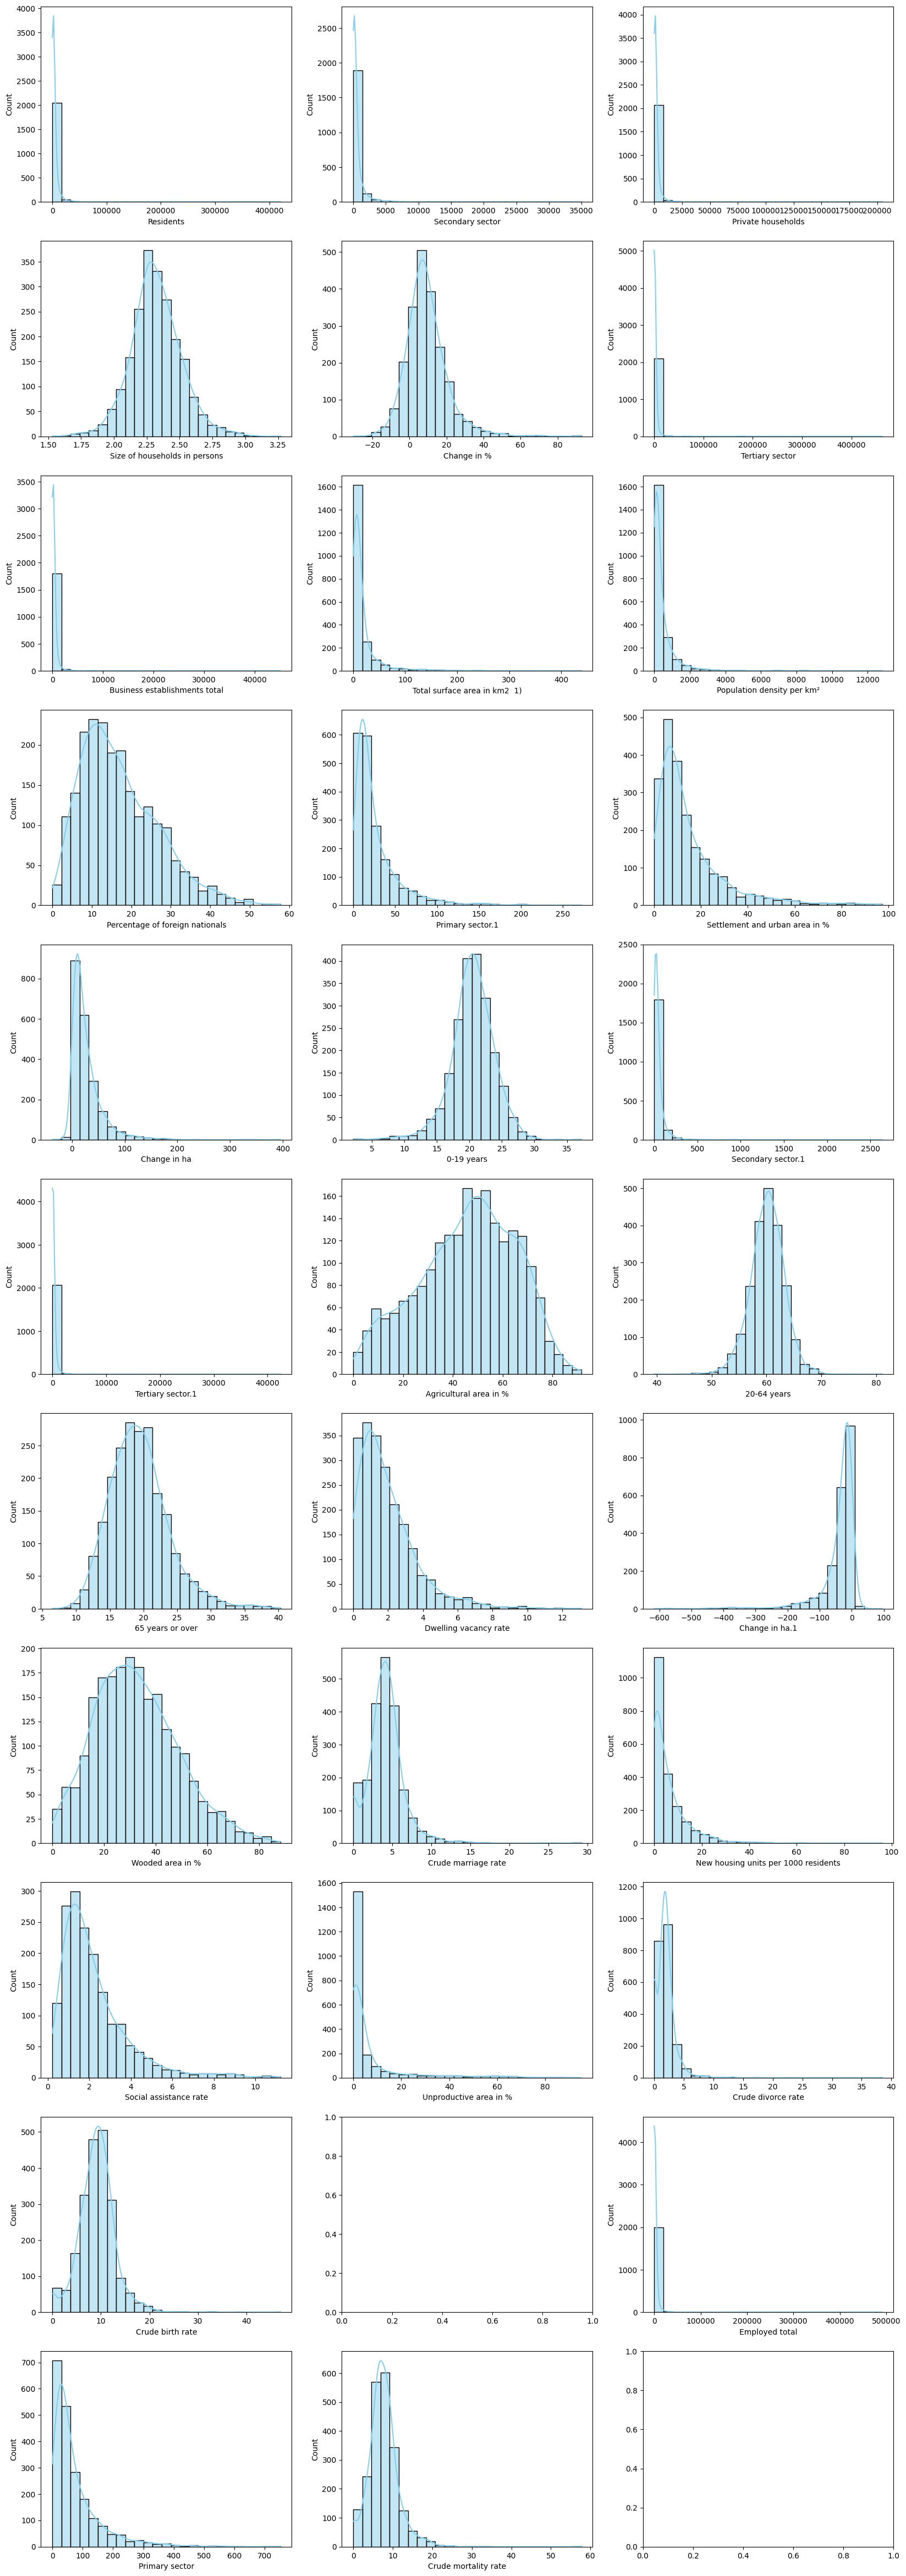

In [15]:
fig, axs = plt.subplots(11, 3, figsize=(20, 60))
i = 0
for column in data.columns:
  if column != "Municipality" and column not in voter_turnout_columns:
    sns.histplot(data=data, bins=25, x=column, kde=True, color="skyblue", ax=axs[ i % 11, i % 3])
    i = i+1

## Calculate correlations and plot them
Calculate Pearsons correlation coeffiecient for each variable and the voter turnout from 2023.
As a comparison value we use the the voter turnout from 2019.

In [16]:
correlations = pd.DataFrame()
m = 0
for column in data_std.columns:
  if column != 'Municipality' and column not in voter_turnout_columns:
    mask = data_std[column].isna()
    df = data_std[~mask] 
    df = df[[column, "turnout2023", "turnout2019"]]
    if len(df.index) > 0:
      new_row = pd.DataFrame({ 
        'correlation 2019' : df['turnout2019'].corr(df[column]),
        'correlation 2023' : df['turnout2023'].corr(df[column])
    }, index=[column])
    correlations = pd.concat([new_row, correlations.loc[:]]) #.reset_index(drop=True)

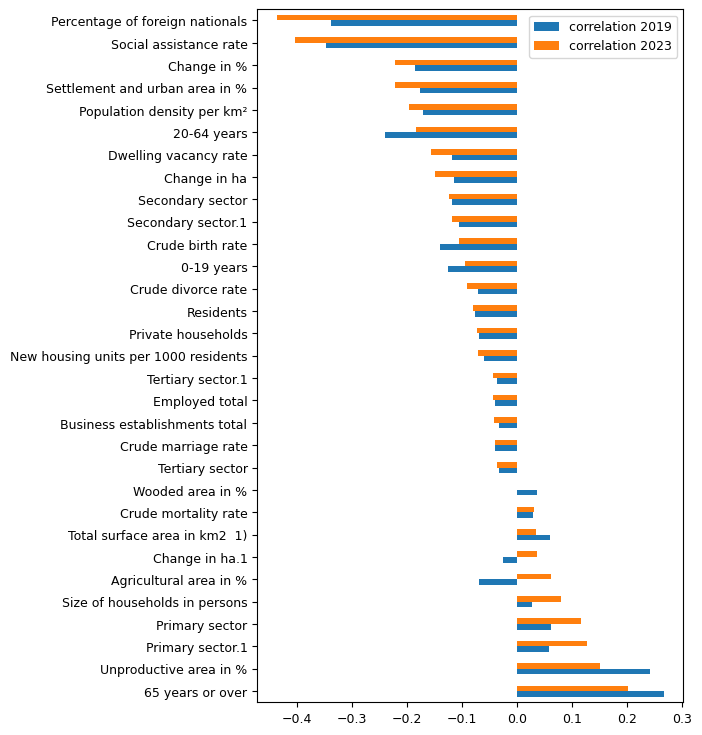

In [17]:
correlations = correlations.sort_values("correlation 2023", ascending=False)     
plt.rcParams.update({'font.size': 9 })
ax = correlations.plot.barh(figsize=(5.5,9))
ax.legend(loc='upper right')

## Scatter plot and linear regression  line

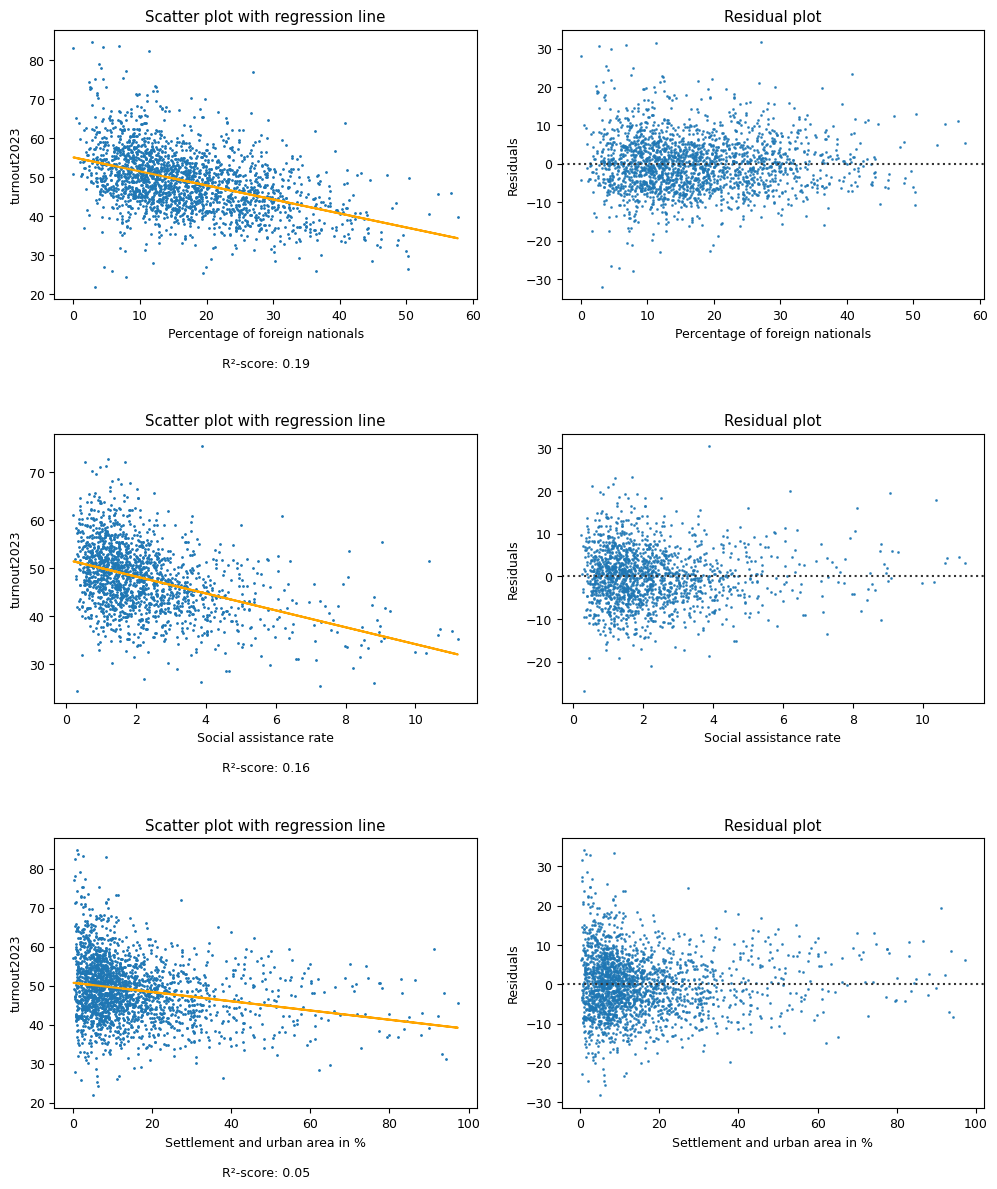

In [18]:
columnsX = ['Percentage of foreign nationals', 'Social assistance rate', 'Settlement and urban area in %'] # Residents 65+ years (%)
columnY = "turnout2023" #
fig, axs = plt.subplots(3, 2, figsize=(12, 14))

# Add more vertical space between the subplots
plt.subplots_adjust(hspace=0.5)

i = 0
for column in columnsX:

  # remove NaN values
  df = data[~data[column].isna()] 

  # linear regression with scipy
  x = df[column].astype(float)
  y = df[columnY].astype(float)
    
  slope, intercept, r, p, se = linregress(x, y)
    
  # Create the scatter plot with regression line on the ax in the first column
  axs[i, 0].set_title("Scatter plot with regression line")
  axs[i, 0].scatter(df[column], df[columnY], s = 1)
  axs[i, 0].plot(x, x*slope + intercept, color="orange")
  axs[i, 0].set_xlabel(column + '\n\nR²-score: ' + str(round(r2_score(y, x*slope + intercept), 2)))
  axs[i, 0].set_ylabel(columnY)

  # Create the residual plot (with seaborn) on the ax in the second column (see paramter ax in residplot)
  axs[i, 1].set_title("Residual plot")
  sns.residplot(x=column, y=columnY, data=df, scatter_kws=dict(s=1), ax=axs[i, 1])
  axs[i, 1].set_ylabel("Residuals")

  i = i + 1

Text(0, 0.5, 'turnout_Neuchatel_2021')

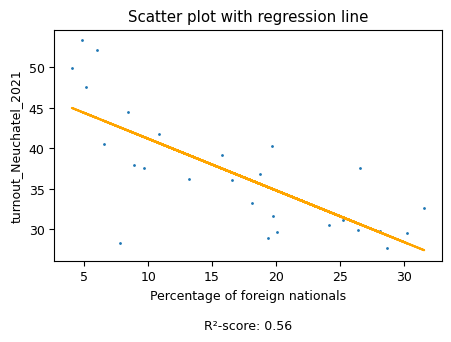

In [19]:
columnX = "Percentage of foreign nationals"
columnY = "turnout_Neuchatel_2021"
fig, axs = plt.subplots(1, 1, figsize=(5, 3))

# remove NaN values
df = data[~data[columnY].isna()] 

# linear regression with scipy
x = df[columnX].astype(float)
y = df[columnY].astype(float)
slope, intercept, r, p, se = linregress(x, y)
    
axs.set_title("Scatter plot with regression line")
axs.scatter(df[columnX], df[columnY], s = 1)
axs.plot(x, x*slope + intercept, color="orange")
axs.set_xlabel(columnX + '\n\nR²-score: ' + str(round(r2_score(y, x*slope + intercept), 2)))
axs.set_ylabel(columnY)

In [52]:
# https://docs.bokeh.org/en/latest/docs/examples/basic/scatters/elements.html
from bokeh.models import Title

## Define columns and remove NaN values
columnX = "Percentage of foreign nationals"
columnY = "turnout2023"
df = data[~data[columnX].isna()] 
    
# Set up the plot: title, tools, sizing mode, margins, colors, labels etc.
TITLE   = "Interactice scatter plot: Each point represents a Municipality (use MoseOver to see the name)"
TOOLS   = "hover,pan,wheel_zoom,reset,save"

p = figure(tools=TOOLS, toolbar_location="above", sizing_mode='stretch_both', title=TITLE, margin=(25,50,25,25))

p.toolbar.logo = "grey"
p.background_fill_color = "#efefef"
p.xaxis.axis_label = columnX
p.yaxis.axis_label = "Voter turnout federal elections 2023"
p.grid.grid_line_color = "white"
p.hover.tooltips = [
    ("Municipality name",   "@Municipality"),
    ("Number of residents", "@Residents"),
    ("Voter turnout federal elections 2023", "@{turnout2023}%"),
    (columnX, "@{Percentage of foreign nationals}%")
]

x = df[columnX]
y = df[columnY]

# Create the ColumnDataSource and AFTER that add values for color and size of the plot points
# Otherwise the s.change.emit() in the callback function will have no effect
source = ColumnDataSource(df)
source.data["color"] = ["steelblue"] * len(x) # steelblue
source.data["size"] = [5] * len(x)

# Use one callback function for all iterative elements (text search, range slider and reset button)
callback = CustomJS(args=dict(s=source), code="""

    const d = s.data;
    const m = d['Municipality']
    const v = d['Residents']
    
    // Set all points to default value
    for (let i = 0; i < d['color'].length; i++) {
        d['color'][i] = "steelblue"
        d['size'][i]  = 5
    }

    // Text search: Highlight municipalities whose names match the search term
    if( typeof cb_obj.value == 'string' ) {
      const search = cb_obj.value
      if( search.length > 0 ) {
        for (let i = 0; i < m.length; i++) {
          if( m[i].includes(search) == true ) {
            d['color'][i] = "firebrick"
            d['size'][i]  = 10
          }
        }
      }
    }
    
    // Range slider: Highlight municipalities whose number residents lies within the selected range
    if( typeof cb_obj.value == 'object' ) {
    
      const v_min = cb_obj.value[0]
      const v_max = cb_obj.value[1]
      
      // Only highlight if some range is selected
      if( v_min > 1 || v_max < 500000 ) {
        for (let i = 0; i < m.length; i++) {
          if( v[i] >= v_min && v[i] <= v_max ) {
            d['color'][i] = "firebrick"
            d['size'][i]  = 7
          }
        }
      }
    }

    s.change.emit();

""")

    
# Create scatter plot
p.scatter(columnX, columnY, size="size", source=source, color="color", line_width=0, line_color="black", alpha=1)

# Linear regression with scipy
slope, intercept, r2, p_1, se = linregress(x, y)
slope = Slope(gradient=slope, y_intercept=intercept, line_color=Inferno11[8], line_width=2)
p.add_layout(slope)

# Create search field
search_input_css = InlineStyleSheet(css=".bk-input-group { padding: 25px 0px 0px 60px }")
search_input = TextInput(value="", title="Search by Municipality name", stylesheets=[search_input_css])
search_input.js_on_change("value", callback)

# Create range slider
range_slider_residents_css = InlineStyleSheet(css=".bk-input-group { padding: 30px 0px 0px 20px }")
range_slider_residents = RangeSlider(start=1, end=500000, value=(1,500000), step=100, title="Municipalities by number of residents", stylesheets=[range_slider_residents_css])
range_slider_residents.js_on_change("value", callback)

# Create reset button
button_reset_css = InlineStyleSheet(css=".bk-btn-group { padding: 45px 0px 0px 50px }")
button_reset = Button(label="Reset", stylesheets=[button_reset_css])
button_reset.js_on_event(events.ButtonClick, callback)

## Create the layout: the input elements in a row, then the plot below (column)
layout_input = row(search_input, range_slider_residents, button_reset)

# For some reason following command raised an error when "Run All" (in jupyter notebook)
# It worked, with "Run" (this cell only)
#layout = column(layout_input, p, sizing_mode='stretch_both')
#show(layout)

## Mediation analysis

In [21]:
columnsX = ["Percentage of foreign nationals", "Social assistance rate"]
columnY  = "turnout2023"

df     = data
df_std = data_std

for column in columnsX:
  df_std = df_std[~df_std[column].isna()] 
  df     = df[~df[column].isna()] 

x  = df[columnsX] #.astype(float)
x1 = df["Percentage of foreign nationals"]
x2 = df["Social assistance rate"]
y  = df[columnY] #.astype(float)

x_std  = df_std[columnsX] #.astype(float)
x1_std = df_std["Percentage of foreign nationals"]
x2_std = df_std["Social assistance rate"]
y_std  = df_std[columnY] #.astype(float)

In [22]:
sm.add_constant(x1_std, prepend=False)
mod = sm.OLS(y_std, x1_std)
res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:            turnout2023   R-squared (uncentered):                   0.206
Model:                            OLS   Adj. R-squared (uncentered):              0.206
Method:                 Least Squares   F-statistic:                              432.7
Date:                Sat, 18 Nov 2023   Prob (F-statistic):                    1.28e-85
Time:                        11:09:30   Log-Likelihood:                         -2003.3
No. Observations:                1666   AIC:                                      4009.
Df Residuals:                    1665   BIC:                                      4014.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

In [23]:
sm.add_constant(x2_std, prepend=False)
mod = sm.OLS(x1_std, x2_std)
res = mod.fit()

print(res.summary())

                                       OLS Regression Results                                       
Dep. Variable:     Percentage of foreign nationals   R-squared (uncentered):                   0.125
Model:                                         OLS   Adj. R-squared (uncentered):              0.124
Method:                              Least Squares   F-statistic:                              237.5
Date:                             Sat, 18 Nov 2023   Prob (F-statistic):                    3.39e-50
Time:                                     11:09:30   Log-Likelihood:                         -2275.6
No. Observations:                             1666   AIC:                                      4553.
Df Residuals:                                 1665   BIC:                                      4559.
Df Model:                                        1                                                  
Covariance Type:                         nonrobust                                         

In [24]:
sm.add_constant(x_std, prepend=False)
mod = sm.OLS(y_std, x_std)
res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:            turnout2023   R-squared (uncentered):                   0.271
Model:                            OLS   Adj. R-squared (uncentered):              0.270
Method:                 Least Squares   F-statistic:                              309.1
Date:                Sat, 18 Nov 2023   Prob (F-statistic):                   6.89e-115
Time:                        11:09:31   Log-Likelihood:                         -1932.6
No. Observations:                1666   AIC:                                      3869.
Df Residuals:                    1664   BIC:                                      3880.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

In [25]:
x_std = df_std[columnsX] #.astype(float)

sm.add_constant(x, prepend=False)
model = sm.OLS(y_std, x_std)
res = model.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:            turnout2023   R-squared (uncentered):                   0.271
Model:                            OLS   Adj. R-squared (uncentered):              0.270
Method:                 Least Squares   F-statistic:                              309.1
Date:                Sat, 18 Nov 2023   Prob (F-statistic):                   6.89e-115
Time:                        11:09:31   Log-Likelihood:                         -1932.6
No. Observations:                1666   AIC:                                      3869.
Df Residuals:                    1664   BIC:                                      3880.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

In [26]:
# Performa 3. Regression again with standardized values: Regress Y_1 on X_1 and X_2
regr = linear_model.LinearRegression()
regr.fit(x_std, y_std)


# Create two grids the plot the regression planes
x1_mg = np.arange(-2, 5, 0.1) # Percentage of foreeigners
x2_mg = np.arange(-2, 5, 0.1) # Social assistance rate
x1_mg, x2_mg = np.meshgrid(x1_mg, x2_mg)

# Regression equation with coeffiecients for X_1 and X_2
eq1 = regr.coef_[1] * x1_mg + regr.coef_[0] * x2_mg + regr.intercept_

# Hypothetical regression equation with coeffiecient only for X_2 (Mediator)
eq2 = regr.coef_[0] * x2_mg + regr.intercept_

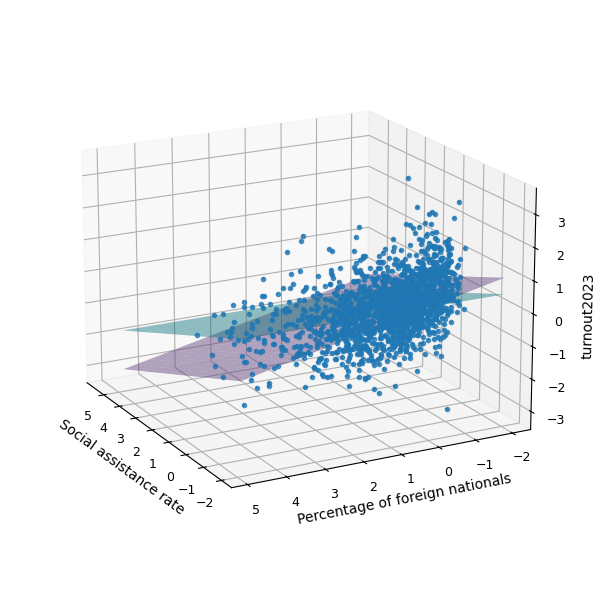

In [27]:
# Create 3D scatter plot with the regression planes
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Zoom the plot out to 0.9 so that axis labels are not cut off
ax.set_box_aspect(aspect=None, zoom=0.9)

# Set up ploz
ax.plot(x2_std, x1_std, y_std, color='tab:blue', zorder=15, linestyle='none', marker='.', alpha=0.75)

# Scatter plot
ax.scatter(x2_std, x1_std, y_std, s=1)  

# Regression plane (Y depending pn X_1 and X_2)
ax.plot_surface(x2_mg, x1_mg, eq1, alpha=0.5, color="tab:purple")

# Hypothetical regression plane (Y depending on X_2)
ax.plot_surface(x2_mg, x1_mg, eq2, alpha=0.5, color="tab:cyan")

ax.set_xlabel(columnsX[1], fontsize=10) #"Social assistance rate"
ax.set_ylabel(columnsX[0], fontsize=10) # Percentage for foreeign nationals
ax.set_zlabel(columnY,     fontsize=10) # Voter turnout 2023

ax.view_init(elev=18, azim=152)

fig.tight_layout()

In [32]:
# Create the 3D plot from 360 perspectives (azim parameter from 1 to 360)
jj = 1
degree_range = np.arange(1, 360, 1)

for ii in degree_range:
  # Use numbers 360 to 719 for file names (to be able to sort files easily, otherwise 1,11,2,22 etc.)
  jj = ii + 359
  ax.view_init(elev=18, azim=ii)
  # Use temporary directory since the files are only used for an intermediate step
  fig.savefig('tmp/scatterplot-%d.png' % jj, dpi=120, format="png")

In [34]:
images_set = []

# Prepare images: Group files in 4 groups
file_range = np.arange(360, 718, 1)
images = [Image.open('tmp/scatterplot-%d.png' % x) for x in file_range]
images_set.append(images[0:89])
images_set.append(images[90:179])
images_set.append(images[180:269])
images_set.append(images[270:359])

In [35]:
# Since we use the files in web app (HTML/JavaScript) it would be very unfavorable to load 360 image files
# Therefore we concatenate the images to 4 jpg files
# (when images were to concatenated to one big JPG image, python raised an os buffer error, so we use 4 images)
for i, image_set in enumerate(images_set):
  widths, heights = zip(*(i.size for i in image_set))
  new_im = Image.new('RGB', (sum(widths), max(heights)))
  x_offset = 0
  for im in image_set:
    new_im.paste(im, (x_offset, 0))
    x_offset += im.size[0]
    
  new_im.save('docs/scatterplot-3D-animated/scatterplot-3D-all-%d.jpg' % i)

In [31]:
# https://skos.ch/fileadmin/user_upload/skos_main/public/pdf/grundlagen_und_positionen/themen/Soziale_Sicherheit/2019_BFS_Sozialhilfestatistik.pdf
# https://www.bfs.admin.ch/bfs/de/home/statistiken/soziale-sicherheit/sozialhilfe.assetdetail.23845655.html